In [1]:
import requests
import matplotlib.pyplot as plt
import json
import os
import cv2

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
import pandas as pd
import math
import numpy as np

In [5]:
from OSMPythonTools.api import Api
# Tool to search OSM data by name and address
from OSMPythonTools.nominatim import Nominatim
# read-only API that serves up custom selected parts of the OSM map data
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from shapely.geometry import Point, Polygon

In [6]:
pd_villages = pd.read_gbq('SELECT * FROM `sidhouses.osm_data.villages`')

In [7]:
village_row_df = pd_villages[pd_villages['name'].str.lower()=='monnon']
village_row_df

osm_id     area_id type    place district    name  \
329  377129182  2777129182  way  village    Nikki  MONNON   

                                                 link              lat  \
329  https://www.openstreetmap.org/edit?way=377129182  9.8425125458573   

                  lon           perim               area  \
329  3.17886415922568  2.807612420215  0.311161616935007   

                                          boundary_lat  \
329  [9.8440377, 9.8434957, 9.8424667, 9.8407571, 9...   

                                          boundary_lon  nb_buildings  \
329  [3.1763558, 3.1760854, 3.176216, 3.1761237, 3....            -1   

     build_dens  pop_est  building_density  population_est_building  
329         0.0      0.0               NaN                      NaN

In [8]:
vil_lat = float(village_row_df['lat'])
vil_lon = float(village_row_df['lon'])

In [9]:
input_json = json.load(open('inputs.json'))

In [10]:
input_json['API_KEY'] = os.environ["API_KEY_MAPS"]
input_json['API_ENDPOINT_URL'] = "https://maps.googleapis.com/maps/api/staticmap"

In [11]:
input_json['image_params']['zoom']=17

In [12]:
params = {
    'center': str(vil_lat) + ',' + str(vil_lon),
    'zoom': input_json['image_params']['zoom'],
    'maptype': input_json['image_params']['maptype'],
    'size': str(input_json['image_params']['size']) + 'x' + str(input_json['image_params']['size']),
    'scale':input_json['image_params']['scale'],
    'key': input_json['API_KEY'],
}

# make the request to the Maps Static API
res = requests.get(url = input_json['API_ENDPOINT_URL'], params = params)

In [13]:
im_name =village_row_df['name'].iloc[0]+'.jpg'

In [14]:
f = open(im_name,'wb')

In [15]:
f.write(res.content)

201582

In [16]:
f.close()

In [17]:
img = cv2.imread(im_name)

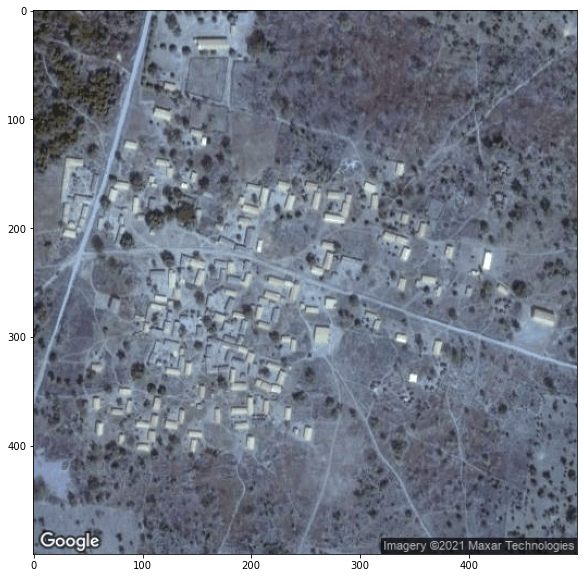

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [19]:
building_query = overpassQueryBuilder(
            area=village_row_df['area_id'].iloc[0], elementType='way', selector="building", out="geom")

# Make the query
building_res = Overpass().query(building_query)

In [20]:
DEG_to_KM2 = 13000
DEG_to_KM = 130

In [21]:
# Transform response into json
building_json = building_res.toJSON()
new_building_data = []

# Loop throught the elements in the response
for ele in building_json['elements']:
    geo_df = pd.DataFrame.from_records(ele['geometry'])
    poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
    point = Point(poly.centroid.x, poly.centroid.y)
    boudary_lat = str(geo_df['lat'].tolist())
    boudary_lon = str(geo_df['lon'].tolist())
    ele_row = [
        ele.get('id', 0),                    # osm_id
        ele.get('type', ''),                 # type
        village_row_df['district'].values[0],         # district
        village_row_df['name'].values[0],             # village
        str(poly.centroid.y),               # lat
        str(poly.centroid.x),               # lon
        str(poly.length * DEG_to_KM),       # perim
        str(poly.area * DEG_to_KM2),        # area
        boudary_lat,                        # boudary_lat
        boudary_lon,                        # boudary_lon
        poly,                               # polygon
        point,                              # point
    ]

    new_building_data.append(ele_row)
    

In [22]:
len(new_building_data)

265

In [23]:
new_building_data[0]

[743114021,
 'way',
 'Nikki',
 'MONNON',
 '9.845318326399196',
 '3.1780025478950193',
 '0.1019463168778451',
 '0.00040417194999977464',
 '[9.8453833, 9.8452733, 9.8452533, 9.8453634, 9.8453833]',
 '[3.177866, 3.177858, 3.178139, 3.1781471, 3.177866]',

In [24]:
new_building_data[0][8]

'[9.8453833, 9.8452733, 9.8452533, 9.8453634, 9.8453833]'

In [25]:
2**3

8

In [360]:
#https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [364]:
vil_lat

9.8425125458573

In [365]:
vil_lon

3.17886415922568

In [361]:
earth_radius= 6378137
d_lat = distance_on_unit_sphere(vil_lat, vil_lon, vil_lat+1, vil_lon)*earth_radius
d_lon = distance_on_unit_sphere(vil_lat, vil_lon, vil_lat, vil_lon+1)*earth_radius
const =  2 * math.pi * earth_radius /256
m_per_px = const * math.cos(vil_lat * math.pi / 180) / math.pow(2, input_json['image_params']['zoom'])

deg_per_m_lat = 1 / (d_lat) 
deg_per_m_lon = 1 / (d_lon)

img_size_deg_lat = m_per_px * deg_per_m_lat * (input_json['image_params']['size'])  # m/px * deg/m * px = deg
img_size_deg_lon = m_per_px * deg_per_m_lon * (input_json['image_params']['size'])  # m/px * deg/m * px = deg

lat_0 = vil_lat + (img_size_deg_lat / 2)
lon_0 = vil_lon - (img_size_deg_lon / 2)

deg_per_px_lat = deg_per_m_lat*m_per_px
deg_per_px_lon = deg_per_m_lon*m_per_px

print(deg_per_px_lat,deg_per_px_lon)

1.0570921910767506e-05 1.0728840038803725e-05


In [362]:
img_copy = img.copy()
for a in new_building_data:
    lat = float(a[4])
    lon = float(a[5])
    
    lat_px = (lat_0 - lat) / deg_per_px_lat
    lon_px = (lon - lon_0) / deg_per_px_lon
    cv2.circle(img_copy, (int(lon_px), int(lat_px)), 2, (0, 255, 0), -1)
    
    house = [[(float(lonn) - lon_0) / deg_per_px_lon,(lat_0 - float(latt)) / deg_per_px_lat]
             for latt,lonn in zip(eval(a[8]),eval(a[9]))
            ]
    vertices = np.array(house,dtype=np.int32)
    pts = vertices.reshape((-1,1,2))
    cv2.polylines(img_copy,[pts],isClosed=True,color=(0,0,255),thickness=1)

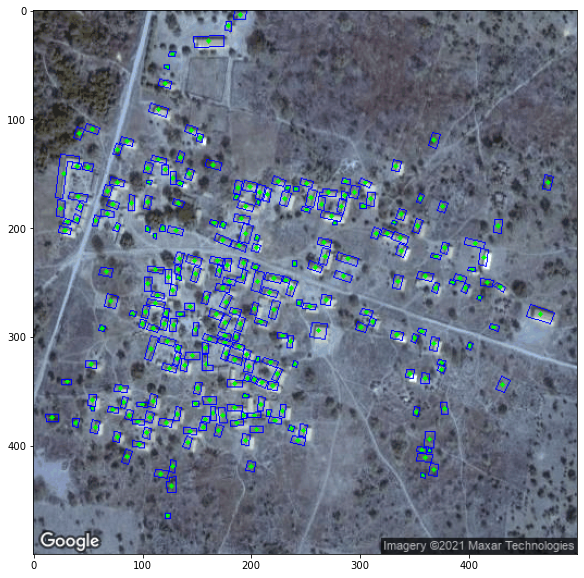

In [363]:
plt.figure(figsize=(20,10))
plt.imshow(img_copy)

In [197]:
## GET COLOR TO CLEAN NEW HOUSES

In [166]:
most_pix = pd.read_gbq('SELECT * FROM `sidhouses.output_data.house_pixels_counts`')

In [167]:
most_pix.columns

Index(['pixel', 'count'], dtype='object')

In [168]:
most_pix['count'].describe()

count    2712.000000
mean      106.742257
std       298.104284
min         1.000000
25%         4.000000
50%        12.000000
75%        53.000000
max      4475.000000
Name: count, dtype: float64

In [173]:
tr_pixels=most_pix[50 < most_pix['count']]['pixel'].apply(eval).apply(list).to_list()

In [178]:
img_copy = img.copy()
img = img.copy()
for a in new_building_data:
    lat = float(a[4])
    lon = float(a[5])
    
    lat_px = (lat_0 - lat) / deg_per_px_lat
    lon_px = (lon - lon_0) / deg_per_px_lon
    
    height = img.shape[0]
    width = img.shape[1]

    mask = np.zeros((height, width), dtype=np.uint8)
    house = [[(float(lonn) - lon_0) / deg_per_px_lon,(lat_0 - float(latt)) / deg_per_px_lat]
             for latt,lonn in zip(eval(a[8]),eval(a[9]))
            ]
    vertices = np.array(house,dtype=np.int32)
    pts = vertices.reshape((-1,1,2))
    
    
    cv2.fillConvexPoly(mask, pts, (255))

    res = cv2.bitwise_and(img,img,mask = mask)

    rect = cv2.boundingRect(pts) # returns (x,y,w,h) of the rect
    cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
    
    house_pixels = cropped.reshape(cropped.shape[0]*cropped.shape[1],cropped.shape[2])
    unique, counts = np.unique(house_pixels, return_counts=True,axis=0)
    df_h_pixels = pd.DataFrame({'pixel':list(unique),'counts':counts})
    df_h_pixels = df_h_pixels[df_h_pixels['pixel'].apply(str) != "[0 0 0]"]
    if 0 < len(df_h_pixels):
        n_house_pix = df_h_pixels[df_h_pixels['pixel'].apply(list).isin(tr_pixels)]['counts'].sum()
        n_pix = df_h_pixels['counts'].sum()
        ind= n_house_pix/n_pix
        #print('{}%'.format(round(100*ind)))
        #plt.figure(figsize=(20,10))
        #plt.imshow(res)
        #plt.show()
        if 0.2 <ind:
            cv2.polylines(img_copy,[pts],isClosed=True,color=(0,0,255),thickness=1)
            cv2.circle(img_copy, (int(lon_px), int(lat_px)), 2, (0, 255, 0), -1)

/opt/anaconda3/envs/sid/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


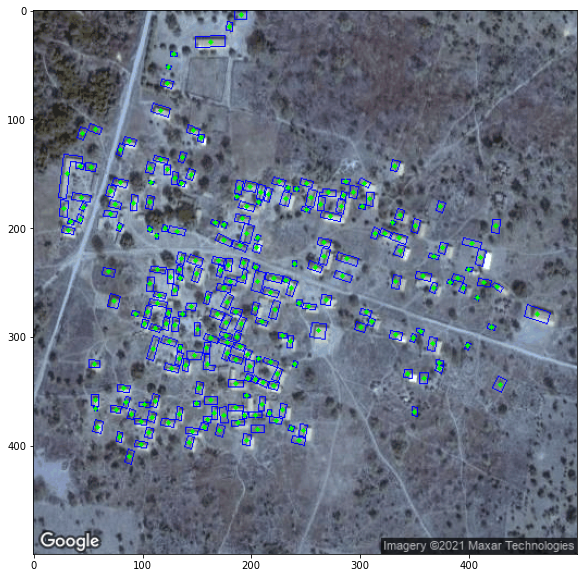

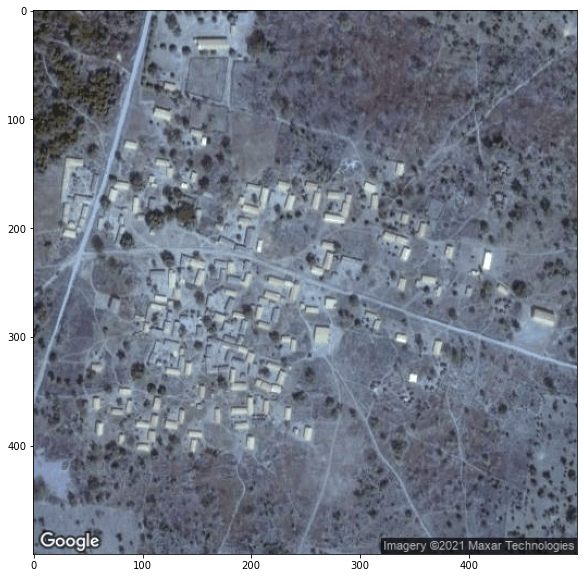

In [180]:
plt.figure(figsize=(20,10))
plt.imshow(img_copy)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(img)

In [35]:
def test(village):
    village_row_df = pd_villages[pd_villages['name'].str.lower()==village]
    vil_lat = float(village_row_df['lat'])
    vil_lon = float(village_row_df['lon'])
    input_json = json.load(open('inputs.json'))
    input_json['API_KEY'] = os.environ["API_KEY_MAPS"]
    input_json['API_ENDPOINT_URL'] = "https://maps.googleapis.com/maps/api/staticmap"
    input_json['image_params']['zoom']=17
    params = {
        'center': str(vil_lat) + ',' + str(vil_lon),
        'zoom': input_json['image_params']['zoom'],
        'maptype': input_json['image_params']['maptype'],
        'size': str(input_json['image_params']['size']) + 'x' + str(input_json['image_params']['size']),
        'scale':input_json['image_params']['scale'],
        'key': input_json['API_KEY'],
    }

    # make the request to the Maps Static API
    res = requests.get(url = input_json['API_ENDPOINT_URL'], params = params)

    im_name =village_row_df['name'].iloc[0]+'.jpg'
    f = open(im_name,'wb')
    f.write(res.content)
    f.close()
    img = cv2.imread(im_name)
    plt.figure(figsize=(20,10))
    plt.imshow(img)

    building_query = overpassQueryBuilder(
                area=village_row_df['area_id'].iloc[0], elementType='way', selector="building", out="geom")

    # Make the query
    building_res = Overpass().query(building_query)
    DEG_to_KM2 = 13000
    DEG_to_KM = 130

    # Transform response into json
    building_json = building_res.toJSON()
    new_building_data = []

    # Loop throught the elements in the response
    for ele in building_json['elements']:
        geo_df = pd.DataFrame.from_records(ele['geometry'])
        poly = Polygon(zip(geo_df['lon'], geo_df['lat']))
        point = Point(poly.centroid.x, poly.centroid.y)
        boudary_lat = str(geo_df['lat'].tolist())
        boudary_lon = str(geo_df['lon'].tolist())
        ele_row = [
            ele.get('id', 0),                    # osm_id
            ele.get('type', ''),                 # type
            village_row_df['district'].values[0],         # district
            village_row_df['name'].values[0],             # village
            str(poly.centroid.y),               # lat
            str(poly.centroid.x),               # lon
            str(poly.length * DEG_to_KM),       # perim
            str(poly.area * DEG_to_KM2),        # area
            boudary_lat,                        # boudary_lat
            boudary_lon,                        # boudary_lon
            poly,                               # polygon
            point,                              # point
        ]

        new_building_data.append(ele_row)

    d_lon = distance_on_unit_sphere(vil_lat, vil_lon, vil_lat, vil_lon+1)*6371*1000
    d_lat = distance_on_unit_sphere(vil_lat, vil_lon, vil_lat+1, vil_lon)*6371*1000

    m_per_px_lat = 156543.03392 * math.cos(vil_lat * math.pi / 180) / math.pow(2, input_json['image_params']['zoom'])
    m_per_px_lon = 156543.03392 * math.cos(vil_lon * math.pi / 180) / math.pow(2, input_json['image_params']['zoom'])


    deg_per_m_lat = 1 / (d_lat) 
    deg_per_m_lon = 1 / (d_lon)
    img_size_deg_lat = m_per_px_lat * deg_per_m_lat * (input_json['image_params']['size'])  # m/px * deg/m * px = deg
    img_size_deg_lon = m_per_px_lon * deg_per_m_lon * (input_json['image_params']['size'])  # m/px * deg/m * px = deg

    lat_0 = vil_lat + (img_size_deg_lat / 2)
    lon_0 = vil_lon - (img_size_deg_lon / 2)

    deg_per_px_lat = deg_per_m_lat*m_per_px_lat
    deg_per_px_lon = deg_per_m_lon*m_per_px_lon

    img_copy = img.copy()
    for a in new_building_data:
        lat = float(a[4])
        lon = float(a[5])

        lat_px = (lat_0 - lat) / deg_per_px_lat
        lon_px = (lon - lon_0) / deg_per_px_lon
        cv2.circle(img_copy, (int(lon_px), int(lat_px)), 2, (0, 255, 0), -1)

        house = [[(float(lonn) - lon_0) / deg_per_px_lon,(lat_0 - float(latt)) / deg_per_px_lat]
                 for latt,lonn in zip(eval(a[8]),eval(a[9]))
                ]
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(img_copy,[pts],isClosed=True,color=(0,0,255),thickness=1)

    plt.figure(figsize=(20,10))
    plt.imshow(img_copy)


[overpass] downloading data: [timeout:25][out:json];area(3137083663)->.searchArea;(way[building](area.searchArea);); out geom;


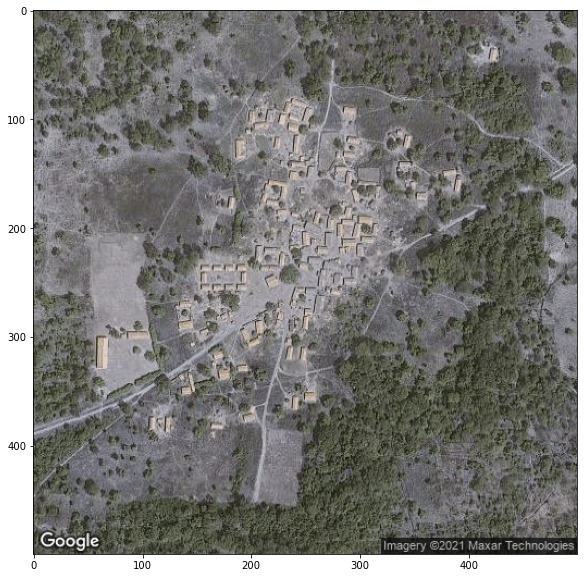

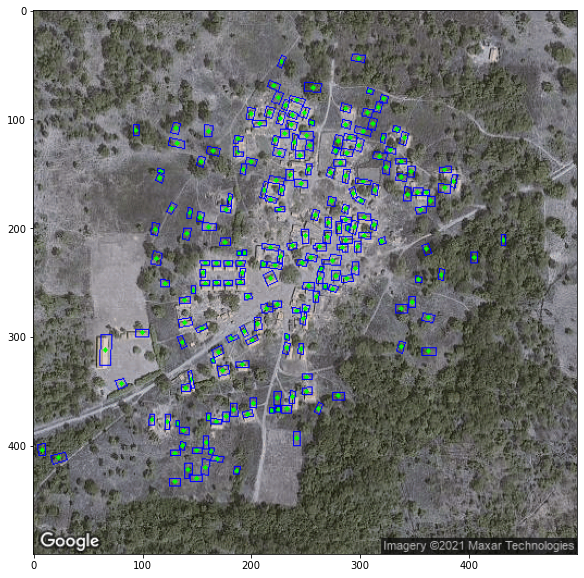

In [37]:
test('sansi')

In [143]:
img = cv2.imread("MONNON.jpg")
height = img.shape[0]
width = img.shape[1]

mask = np.zeros((height, width), dtype=np.uint8)
points = pts
cv2.fillConvexPoly(mask, points, (255))

res = cv2.bitwise_and(img,img,mask = mask)

rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]

In [144]:
house_pixels = cropped.reshape(cropped.shape[0]*cropped.shape[1],cropped.shape[2])

In [145]:
unique, counts = np.unique(house_pixels, return_counts=True,axis=0)

In [146]:
df_h_pixels = pd.DataFrame({'pixel':list(unique),'counts':counts})

In [147]:
df_h_pixels = df_h_pixels[df_h_pixels['pixel'].apply(str) != "[0 0 0]"]

In [148]:
n_house_pix = df_h_pixels[df_h_pixels['pixel'].apply(list).isin(tr_pixels)]['counts'].sum()

In [149]:
n_pix = df_h_pixels['counts'].sum()

In [150]:
n_house_pix/n_pix

0.2753623188405797

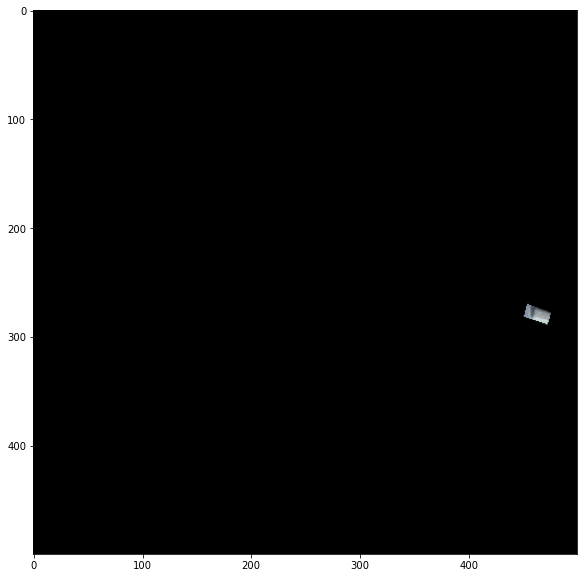

In [152]:
plt.figure(figsize=(20,10))
plt.imshow(res)